# Preprocessing

## Train

In [17]:
from glob import glob
import re
import numpy as np
def convert_path(p):
    # Replace the folder part
    
    p = re.sub(r'^idd20kII/leftImg8bit/train', 'idd20kII/gtFine/train', p)
    # Replace the filename part
    p = re.sub(r'_leftImg8bit\.jpg$', '_gtFine_polygons.json', p)
    return p

image = glob('idd20kII/leftImg8bit/train/*/*_leftImg8bit.jpg')
labels= [convert_path(p) for p in image]

print(f"Length of the dataset: {len(image)} and {len(labels)}" )
print(image[0], labels[0])

Length of the dataset: 7034 and 7034
idd20kII/leftImg8bit/train/368/frame1156_leftImg8bit.jpg idd20kII/gtFine/train/368/frame1156_gtFine_polygons.json


In [18]:

train_dataset = list(zip(image, labels))
print(train_dataset[0])

('idd20kII/leftImg8bit/train/368/frame1156_leftImg8bit.jpg', 'idd20kII/gtFine/train/368/frame1156_gtFine_polygons.json')


# Validation 

In [19]:
from glob import glob
import re
import numpy as np

def convert_path(p):
    # Replace the folder part    
    p = re.sub(r'^idd20kII/leftImg8bit/val', 'idd20kII/gtFine/val', p)
    # Replace the filename part
    p = re.sub(r'_leftImg8bit\.jpg$', '_gtFine_polygons.json', p)
    return p

image = glob('idd20kII/leftImg8bit/val/*/*_leftImg8bit.jpg')
labels= [convert_path(p) for p in image]

print(f"Length of the dataset: {len(image)} and {len(labels)}" )
print(image[0], labels[0])

Length of the dataset: 1055 and 1055
idd20kII/leftImg8bit/val/557/frame0149_leftImg8bit.jpg idd20kII/gtFine/val/557/frame0149_gtFine_polygons.json


In [20]:
val_dataset=list(zip(image,labels))
print(val_dataset[0])

('idd20kII/leftImg8bit/val/557/frame0149_leftImg8bit.jpg', 'idd20kII/gtFine/val/557/frame0149_gtFine_polygons.json')


# Converting into COCO format

In [21]:
import json

def build_category_mapping(train_dataset, val_dataset)->dict:
    """
    Extracts the categories from the dataset and builds a mapping from category to id.
    Args:
        train_dataset (list): A list of tuples where the first element is the image path and the second element is the label path.
        val_dataset (list):  A list of tuples where the first element is the image path and the second element is the label path.

    Returns:
        dict: A dictionary mapping from category to id.
    """
    label_set = set()

    for dataset in [train_dataset, val_dataset]:
        for image_path, label_path in dataset:
            try:
                with open(label_path, 'r') as f:
                    data = json.load(f)
            except Exception as e:
                print(f"Error reading {label_path}: {e}")
                continue
            for obj in data.get("objects", []):
                label = obj.get("label")
                if label is not None:
                    label_set.add(label)

    label_to_id = {label: idx + 1 for idx, label in enumerate(label_set)}
    return label_to_id

categories=build_category_mapping(train_dataset, val_dataset)
print(categories, len(categories))

{'animal': 1, 'rider': 2, 'bus': 3, 'billboard': 4, 'out of roi': 5, 'drivable fallback': 6, 'fallback background': 7, 'motorcycle': 8, 'fence': 9, 'ego vehicle': 10, 'guard rail': 11, 'rail track': 12, 'bridge': 13, 'ground': 14, 'non-drivable fallback': 15, 'train': 16, 'sky': 17, 'person': 18, 'traffic sign': 19, 'trailer': 20, 'building': 21, 'bicycle': 22, 'wall': 23, 'caravan': 24, 'car': 25, 'vegetation': 26, 'sidewalk': 27, 'vehicle fallback': 28, 'curb': 29, 'license plate': 30, 'pole': 31, 'obs-str-bar-fallback': 32, 'traffic light': 33, 'rectification border': 34, 'truck': 35, 'autorickshaw': 36, 'unlabeled': 37, 'parking': 38, 'polegroup': 39, 'road': 40, 'tunnel': 41} 41


In [22]:
with open("categories.json", "w") as f:
    json.dump(categories, f, indent=4)
print("Categories saved to categories.json")

Categories saved to categories.json


In [23]:
# Support Functions
def polygon_to_bbox(polygon):
    """
    Convert a polygon (list of [x, y] points) into a bounding box [x_min, y_min, width, height].
    """
    xs = [pt[0] for pt in polygon]
    ys = [pt[1] for pt in polygon]
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return [x_min, y_min, x_max - x_min, y_max - y_min]

def flatten_polygon(polygon):
    """
    Flatten a list of [x, y] into [x1, y1, x2, y2, ...].
    """
    return [coord for pt in polygon for coord in pt]

In [24]:

def convert_to_coco(dataset, output_json, category_mapping):
    """
    Converts the given dataset into COCO format.
    Expects that flatten_polygon and polygon_to_bbox are defined.
    """
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }
    image_id = 1
    annotation_id = 1

    for image_path, label_path in dataset:
        try:
            with open(label_path, 'r') as f:
                data = json.load(f)
        except Exception as e:
            print(f"Error reading {label_path}: {e}")
            continue

        img_width = data.get('imgWidth')
        img_height = data.get('imgHeight')
        if img_width is None or img_height is None:
            print(f"Skipping {label_path} due to missing image dimensions.")
            continue

        coco_output["images"].append({
            "id": image_id,
            "file_name": image_path,
            "width": img_width,
            "height": img_height
        })

        for obj in data.get("objects", []):
            label = obj.get("label")
            polygon = obj.get("polygon")
            if not polygon or label not in category_mapping:
                continue

            # Get the category id from the shared mapping.
            category_id = category_mapping[label]

            # Use the already defined functions to compute segmentation and bbox.
            segmentation = [flatten_polygon(polygon)]
            bbox = polygon_to_bbox(polygon)
            area = bbox[2] * bbox[3]

            annotation = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "segmentation": segmentation,
                "bbox": bbox,
                "area": area
            }
            coco_output["annotations"].append(annotation)
            annotation_id += 1
        
        image_id += 1

    categories=[{"id":value,
                 "name":key}
                   for key,value in category_mapping.items()]
    coco_output["categories"]=categories
    

    # Save the COCO-style JSON file.
    with open(output_json, "w") as f:
        json.dump(coco_output, f, indent=4)
    
    print(f"COCO conversion complete! Saved to {output_json}")

convert_to_coco(train_dataset, "train_output.json", categories)
convert_to_coco(val_dataset, "val_output.json", categories)
convert_to_coco(train_dataset[:1], "test.json", categories)

COCO conversion complete! Saved to train_output.json
COCO conversion complete! Saved to val_output.json
COCO conversion complete! Saved to test.json


In [25]:
with open("label2id.json", "w") as f:
    json.dump(categories, f, indent=4)

id2label = {v: k for k, v in categories.items()}
with open("id2label.json", "w") as f:
    json.dump(id2label, f, indent=4)

In [26]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import os
import random

def initialise_coco(ann_file_path):
    """
    Initialise COCO API with the given annotation file.
    """
    return COCO(ann_file_path)

In [27]:

def plot_coco_annotations(coco, img_id, img_dir):
    """
    Load an image by ID and plot it with all its COCO annotations.
    
    Parameters:
    - coco:    a COCO object
    - img_id:  integer image ID
    - img_dir: directory containing the image files
    """
    # Load image info and data
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image    = plt.imread(img_path)
    
    # Display image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    
    # Load and draw all annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns    = coco.loadAnns(ann_ids)
    for ann in anns:
        x, y, w, h = ann['bbox']
        # draw bbox
        plt.gca().add_patch(
            plt.Rectangle((x, y), w, h,
                          fill=False, linewidth=2, edgecolour='red')
        )
        # draw label
        cat_name = coco.loadCats(ann['category_id'])[0]['name']
        plt.text(x, y - 5, cat_name,
                 fontsize=12, backgroundcolour='white')
    plt.show()

In [28]:
import json

REQUIRED_TOP_LEVEL = {'images', 'annotations', 'categories'}

def validate_coco_json(path):
    """
    Basic sanity check for a COCO JSON:
    - Valid JSON?
    - Contains required top-level keys?
    - Every annotation.image_id appears in images?
    - Every annotation.category_id appears in categories?
    """
    with open(path, 'r') as f:
        data = json.load(f)

    # Top-level keys
    missing = REQUIRED_TOP_LEVEL - data.keys()
    if missing:
        raise ValueError(f"Missing top-level keys: {missing}")

    img_ids = {img['id'] for img in data['images']}
    cat_ids = {cat['id'] for cat in data['categories']}

    for ann in data['annotations']:
        if not isinstance(ann.get('bbox'), list) or len(ann['bbox']) != 4:
            raise ValueError(f"Bad bbox for annotation id {ann.get('id')}: {ann.get('bbox')}")
        if ann['image_id'] not in img_ids:
            raise ValueError(f"Annotation {ann['id']} has unknown image_id {ann['image_id']}")
        if ann['category_id'] not in cat_ids:
            raise ValueError(f"Annotation {ann['id']} has unknown category_id {ann['category_id']}")

    print("Basic COCO JSON checks passed ✔")

validate_coco_json("train_output.json")
validate_coco_json("val_output.json")

Basic COCO JSON checks passed ✔
Basic COCO JSON checks passed ✔


loading annotations into memory...
Done (t=39.42s)
creating index...
index created!


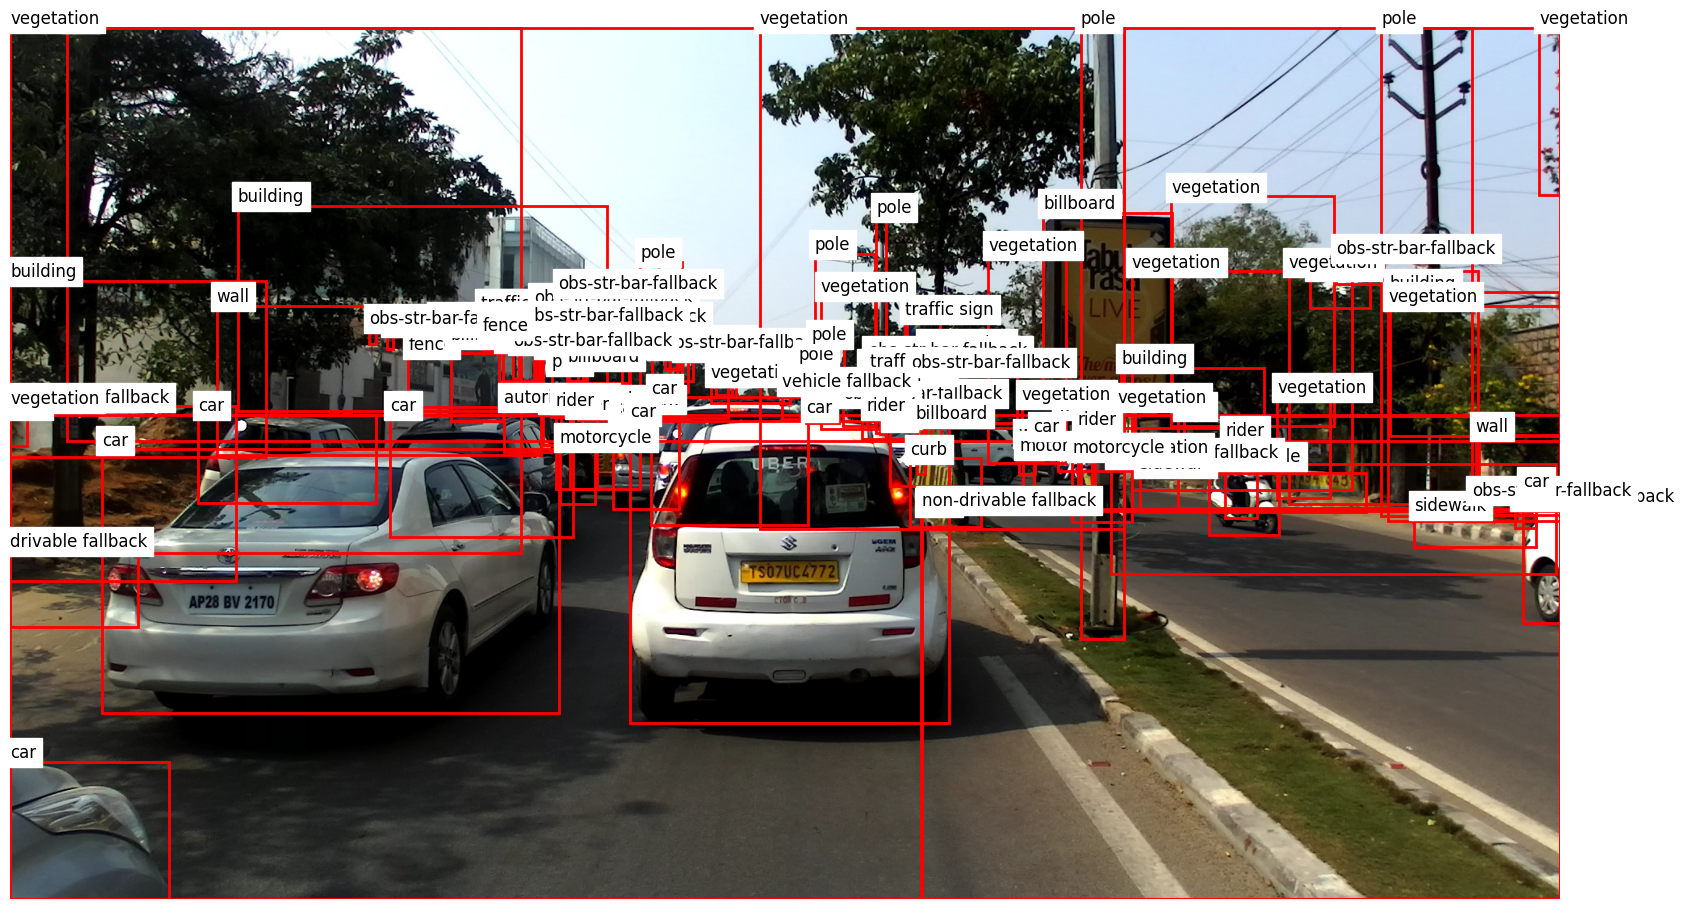

In [29]:


from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import random


ann_file = 'train_output.json'
img_dir  = 'Idd20kII/leftImg8bit/train'

# Initialise COCO API
coco = COCO(ann_file)

# Pick an image ID (e.g. the first one)
img_ids = coco.getImgIds()
img_id  = random.choice(img_ids)
img_info = coco.loadImgs(img_id)[0]

# Load image
img_path = img_info['file_name']
image    = plt.imread(img_path)

# Display
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')

# Load & draw annotations
ann_ids = coco.getAnnIds(imgIds=img_id)
anns    = coco.loadAnns(ann_ids)

for ann in anns:
    x, y, w, h = ann['bbox']  # [x, y, width, height]
    # draw box
    plt.gca().add_patch(
        plt.Rectangle((x, y), w, h,
                      fill=False, linewidth=2, edgecolor='red')
    )
    # add label
    cat_name = coco.loadCats(ann['category_id'])[0]['name']
    plt.text(x, y-5, cat_name,
             fontsize=12, backgroundcolor='white')

plt.show()
